In [74]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [75]:
count = 0
dirs = os.listdir(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata')
for dir in dirs:
    files = list(os.listdir(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images ')
    count = count + len(files)
print('Images Folder has ' + str(count) + 'Images')    

Biji_strawberry Folder has 100 Images 
tumbuhan_dewasa Folder has 102 Images 
tunas Folder has 100 Images 
Images Folder has 302Images


In [76]:
base_dir = r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\Traindata'
img_size = 224
batch = 32
validation_split = 0.1
test_split = 0.1

In [77]:
import tensorflow as tf
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)    

Found 284 files belonging to 3 classes.


In [78]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Biji_strawberry', 'tumbuhan_dewasa', 'tunas']


In [79]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 9
Train Images: 9
Validation Images: 0


In [80]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

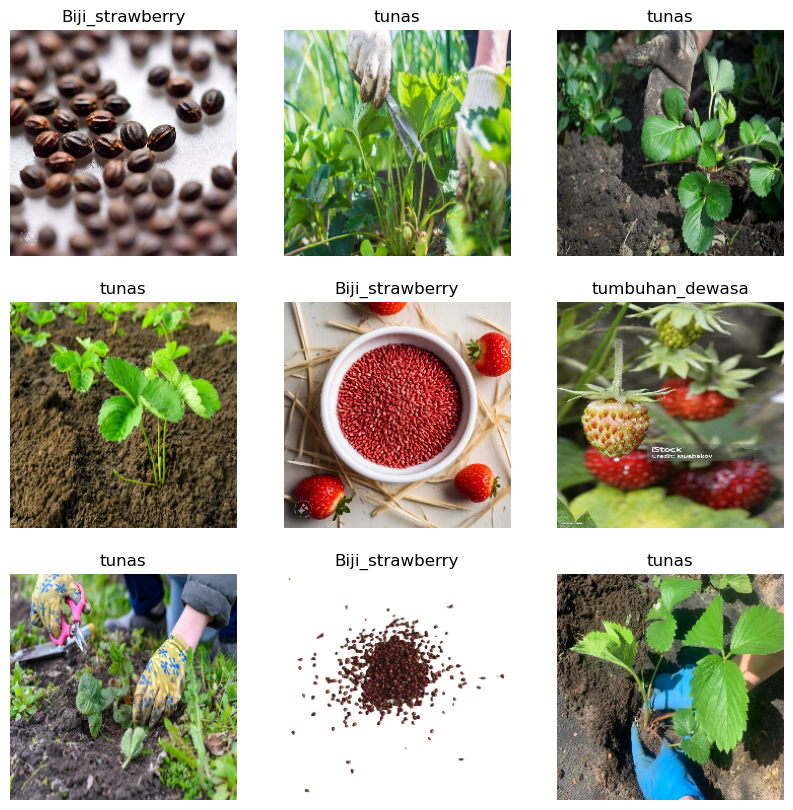

In [81]:
import matplotlib.pyplot as plt
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [82]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 224, 224, 3)


In [83]:
AUTOTUNE = tf.data.AUTOTUNE

In [84]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [85]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [86]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

base_model = MobileNet(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

fine_tune_at = len(base_model.layers)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model =  Sequential([Input(shape=(224, 224, 3)), 
                     data_augmentation, layers.Rescaling(1./255), base_model, 
                     layers.GlobalAveragePooling2D(), Dense(128, activation='relu'),
                     Dropout(0.3), Dense(3, activation='softmax')])

In [87]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)    
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 131,587 (514.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [88]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max')
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.3118 - loss: 1.0986
Epoch 2/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4286 - loss: 1.0985

c:\Users\LENOVO\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.3566 - loss: 1.0985
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.3375 - loss: 1.0984
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.3349 - loss: 1.0984
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3468 - loss: 1.0983
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3764 - loss: 1.0982
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.3209 - loss: 1.0982
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.3686 - loss: 1.0981
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.3819 - loss: 1.0980
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.3655 - loss: 1.0979
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.3607 - loss: 1.0980
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.3763 - loss: 1.0977
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.3261 - loss: 1.0980

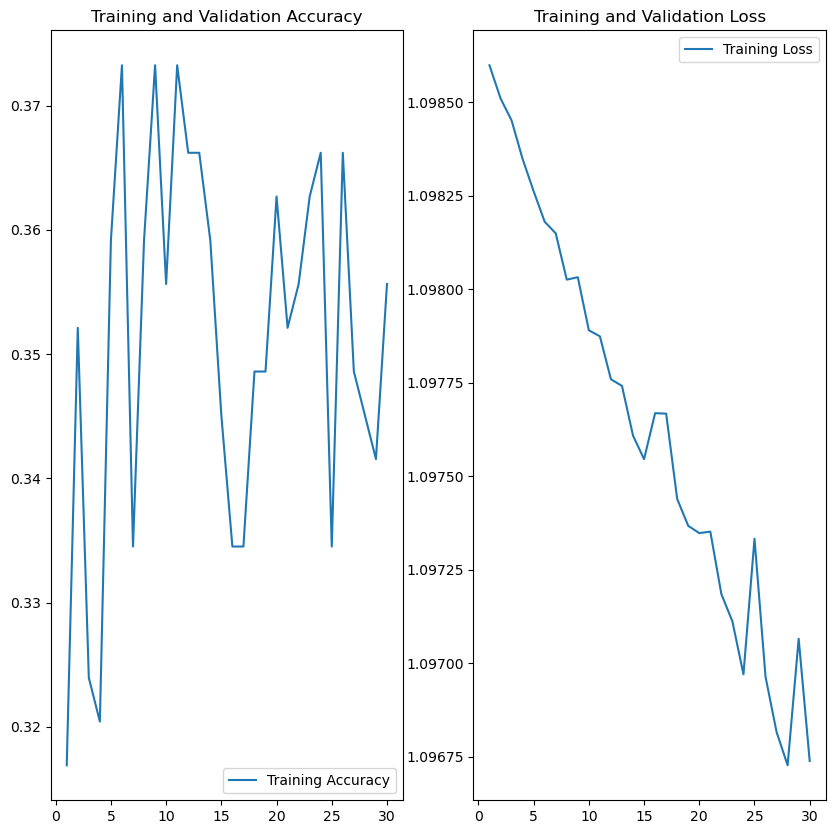

In [89]:
epoch_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epoch_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(epoch_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
model.save('BestModel_MobileNet_Numpy.h5')

In [91]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

In [97]:
def classify_images(image_path, save_path='datatest.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions =  model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"terjadi kesalahan: {e}"

image_paths = [
    r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\test_data\tunas\istockphoto-517610218-612x612.jpg',
    r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\test_data\tumbuhan_dewasa\istockphoto-1322623724-1024x1024.jpg',
]

# Loop melalui semua gambar
for i, image_path in enumerate(image_paths, start=1):
    save_path = f"datatest_{i}.jpg"
    result = classify_images(image_path, save_path=save_path)
    print(result)

terjadi kesalahan: Exception encountered when calling Sequential.call().

Input 0 of layer "mobilenet_1.00_224" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(1, 224, 224, 3)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None
terjadi kesalahan: Exception encountered when calling Sequential.call().

Input 0 of layer "mobilenet_1.00_224" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(1, 224, 224, 3)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None


In [98]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import seaborn as sns

In [99]:
mobileNet_model = load_model(r'BestModel_MobileNet_Numpy.h5')

In [101]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

#memuat model yang sudah dilatih
model = load_model(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\BestModel_MobileNet_Numpy.h5')  # Ganti dengan path model Anda
class_names = ['tunas', 'benih', 'tumbuhan_dewasa'] #kelas yang ada pada model

#fungsi untuk mengklasifikasikan gambar dan menyimpan gambar asli
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        #memuat dan mempersiapkan gambar untuk prediksi
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) #membuat gambar dari path dan mnegubah ukurannya menjadi 180x180 pixel
        input_image_array = tf.keras.utils.img_to_array(input_image) #mengubah gambar jadi array numpy agar bisa di proses model
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  #menambahkan dimensi batch agar sesuai dengan input model
                                                                    #dimensi menjadi (1, 180, 180, 3)

        #melakukan prediksi
        predictions = model.predict(input_image_exp_dim) #melakukan prediksi pada gambar yang telah diproses
        result = tf.nn.softmax(predictions[0]) #menghitung hasil prediksi menggunakan softmax untuk mendapatkan probabilitas tiap kelas
        class_idx = np.argmax(result) #menemukan indeks kelas dengan probabilitas tertinggi
        confidence = np.max(result) * 100 #menghitung confidence dalam persentase

        #menampilkan hasil prediksi dan confidence
        print(f"Prediksi: {class_names[class_idx]}") #menampilkan nama kelas yang diprediksi 
        print(f"Confidence: {confidence:.2f}%") #menampilkan nilai confidence

        #menyimpan gambar asli tanpa teks
        input_image = Image.open(image_path) #membuka gambar yang ada di path
        input_image.save(save_path) #menyimpan gambar asli ke dalam path yang telah ditentukan

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

#contoh penggunaan fungsi
result = classify_images(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\test_data\tunas\istockphoto-517610218-612x612.jpg', save_path='tunas.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
Prediksi: benih
Confidence: 58.48%
Prediksi: benih dengan confidence 58.48%. Gambar asli disimpan di tunas.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


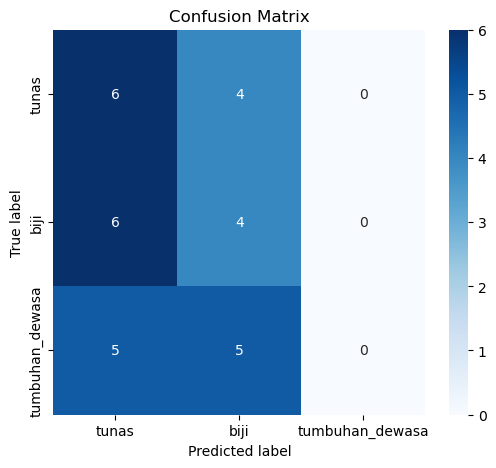

Confusion Matrix:
 [[6 4 0]
 [6 4 0]
 [5 5 0]]
Akurasi: 0.3333333333333333
Presisi: [0.35294118 0.30769231        nan]
Recall: [0.6 0.4 0. ]
F1 Score: [0.44444444 0.34782609        nan]


In [102]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

#memuat model yang telah dilatih sebelumnya
mobileNet_model = load_model(r'C:\Users\LENOVO\Documents\Semester 5\Pembelajaran mesin dan mendalam\Bagian 6\Tugas6_B_11692\BestModel_MobileNet_Numpy.h5')#gunakan path masing masing ya

#memuat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', #direktori data uji
    labels='inferred', #label otomatis dari subfolder yang ada
    label_mode='categorical',  #menghasilkan label dalam bentuk one-hot encoding
    batch_size=32, #ukuran batch untuk pemrosesan
    image_size=(180, 180) #ukuran gambar yang akan diproses
)

#prediksi model
y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  #konversi ke kelas prediksi

#ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
true_labels = [] #menyimpan label asli dalam bentuk indeks
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  #konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels) #mengkonversi list ke tensor untuk perhitungan

#membuat confusion matrix untuk evaluasi
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

#menghitung akurasi berdasarkan confusion matrix
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

#mnghitung presisi dan recall dari confusion matrix
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

#menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

#visualisasi Confusion Matrix
plt.figure(figsize=(6, 5)) #mengatur ukuran gambar
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', #annot=True untuk menampilkan angka di dalam setiap sel matriks
                                                                 #fmt='d' untuk menampilkan bilangan bulat tanpa desimal
            xticklabels=["tunas", "biji", "tumbuhan_dewasa"], yticklabels=["tunas", "biji", "tumbuhan_dewasa"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())